In [14]:
import os 
import numpy as np 
import xarray as xr
import pandas as pd
import scipy.linalg as LA
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
plt.rcParams['text.usetex'] = True

In [15]:
fp      = '../Synthetic/Farinotti_smooth/Exp_01_elevation_dependent/hdf5/'
files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2000a' in file and 'dt_1'])
xarrays = []

for file in files:
    xarrays.append(xr.open_dataset(file))
    
mf_dataset = xr.concat(xarrays, 
                       pd.Index(data = np.arange(2.0, 2.51, 0.01), name='Delta_MB'))

mf_dataset["H"] = mf_dataset.z_s - mf_dataset.z_b

In [16]:
np.arange(2.0, 2.51, 0.01)

array([2.  , 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.1 ,
       2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.2 , 2.21,
       2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.3 , 2.31, 2.32,
       2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.4 , 2.41, 2.42, 2.43,
       2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 ])

In [17]:
test = xr.open_dataset(files[41])
test["H"] = test.z_s - test.z_b

In [18]:
# xr.open_mfdataset('../Synthetic/Exp_01_elevation_dependent/hdf5/*.nc',
#                   concat_dim=pd.Index(data = np.arange(2.0, 2.51, 0.01),  name='Delta_MB'), 
#                   coords='all')

In [19]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

############################################################
# For Seting up the colorbar: 
#    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
############################################################

colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB), vmax=np.max(mf_dataset.Delta_MB))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(mf_dataset.Delta_MB)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0])/2.0
boundaries = np.linspace(mf_dataset.Delta_MB[0] - halfdist, 
                         mf_dataset.Delta_MB[-1] + halfdist, 
                         len(mf_dataset.Delta_MB) + 1)

In [6]:
Vol = mf_dataset.H.integrate("x") / mf_dataset.H.sel(t=0).integrate("x")

In [12]:
test_VOl = test.H.integrate("x")  / test.H.sel(t=0).integrate("x")

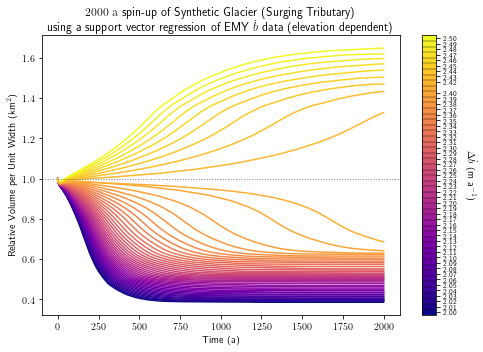

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))

for delta_mb in Vol.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    ax.plot(Vol.t, Vol.sel(Delta_MB=delta_mb), color=color)

ax.axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)
  
ax.plot(test_VOl.t, test_VOl, color=colormap(normalize(2.41)))

cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=mf_dataset.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

ax.set_title(r'\begin{center} $2000 \; \rm{a}$ spin-up of Synthetic Glacier (Surging Tributary) \\ using a support vector regression of EMY $\dot b$ data (elevation dependent) \end{center}',pad = 20.0)
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('Time (a)')
    
cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=7) 

fig.tight_layout()
fig.savefig('../plots/denser_Vol_versus_time.png', dpi=400, bbox_inches='tight', facecolor='w')

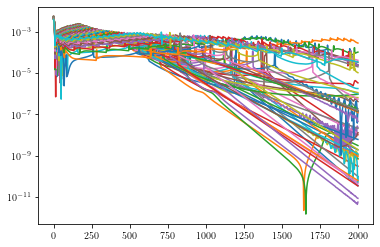

In [21]:
fig, ax = plt.subplots()

for delta_mb in Vol.Delta_MB:
    plt.plot(Vol.t, np.abs(Vol.differentiate("t")).sel(Delta_MB=delta_mb))

plt.yscale('log')

fig.savefig('/Users/andrewnolan/Desktop/test_dV.png', dpi=800, bbox_inches='tight',facecolor='w')

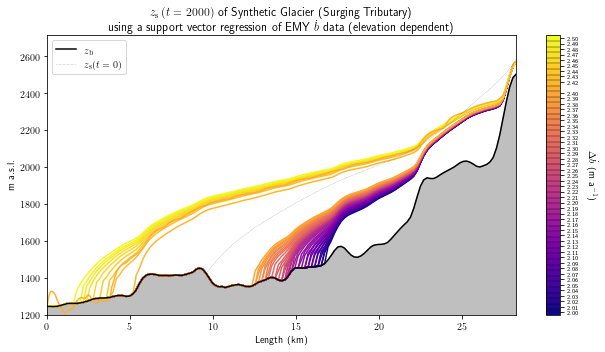

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))

for delta_mb in Vol.Delta_MB:
    color = colormap(normalize(delta_mb))
    ax.plot(mf_dataset.x/1000., mf_dataset.isel(t=-1).z_s.sel(Delta_MB=delta_mb), color=color)
    
ax.plot(test.x/1000., test.isel(t=-1).z_s, color = colormap(normalize(2.41)))
ax.plot(mf_dataset.x/1000., mf_dataset.isel(t=0,Delta_MB=0).z_b, color='k', label=r'$z_{\rm b}$')
ax.plot(mf_dataset.x/1000., mf_dataset.isel(t=0,Delta_MB=0).z_s, 
        color='k', ls=':', lw=0.5, alpha = 0.5, label=r'$z_{\rm s}(t=0)$')

ax.fill_between(mf_dataset.x/1000., mf_dataset.isel(t=0,Delta_MB=0).z_b, color='gray', alpha=0.5)


cbar = fig.colorbar(s_map, 
                    spacing='proportional', 
                    ticks=mf_dataset.Delta_MB, 
                    ax=ax, 
                    boundaries=boundaries, 
                    drawedges=True, 
                    format='%2.2f')

ax.set_title(r'\begin{center} $z_{\rm s} \left( t=2000 \right)$ of Synthetic Glacier (Surging Tributary) \\ using a support vector regression of EMY $\dot b$ data (elevation dependent) \end{center}',pad = 20.0)

ax.legend(loc=2)

ax.set_xlabel('Length (km)')
ax.set_ylabel('m a.s.l.')
ax.set_xlim(0,np.max(mf_dataset.x)/1000.)
ax.set_ylim(1200, None)

cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=6) 

fig.tight_layout()
fig.savefig('../plots/denser_final_Z_s.png', dpi=400, bbox_inches='tight', facecolor='w')

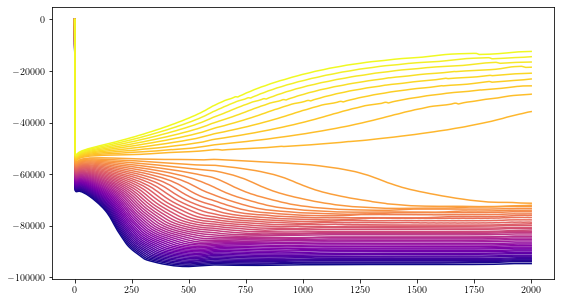

In [23]:
fig, ax = plt.subplots(figsize=(9, 5))

for delta_mb in Vol.Delta_MB:
    color = colormap(normalize(delta_mb))
    
    ax.plot(Vol.t, mf_dataset.b_dot.integrate("x").sel(Delta_MB=delta_mb), color=color)
    


In [ ]:
plt.plot((mf_dataset.isel(Delta_MB=0).b_dot * mf_dataset.isel(Delta_MB=0).H).integrate("x"))
#plt.yscale('log')

In [ ]:
(mf_dataset.isel(Delta_MB=41).b_dot*2*Vol.isel(Delta_MB=41)).integrate("x")

In [ ]:
np.sum(mf_dataset.isel(Delta_MB=0,t=-1).b_dot)

In [ ]:
Vol.isel(Delta_MB=0, t=-1)

In [ ]:
#mf_dataset.isel(Delta_MB=41).H.plot.pcolormesh

In [ ]:
#mf_dataset.isel(Delta_MB=41).H.plot.pcolormesh

In [ ]:
#! cat ../Synthetic/Exp_01_elevation_dependent/SaveData/lk_pre_1002a_mb_0.0_off.dat.names 

In [ ]:
####################################################################################
# load inital conidtions used in model run 
####################################################################################
#x_c = np.loadtxt('../Synthetic/Exp_01_elevation_dependent/SaveData/lk_pre_500a_mb_2.50_off.dat') # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

# # flip all axes so x-coord is descending not ascending
# x_c = x_c[::-1]
# x_c = x_c.reshape(-1,143,12)
z_s = z_s[::-1]
# z_b = z_b[::-1] 

#####################################################################################
# interpolate inital conditions and evaluate a Elmer Grid cell locations
#####################################################################################
f   = interpolate.interp1d(z_s[1], z_s[0])

In [ ]:
dats = [fn for fn in os.listdir('../Synthetic/Exp_01_elevation_dependent/SaveData/') if fn.endswith('.dat') and '1002a' in fn]
# Sort the list based on MB offset
#dats.sort(key=lambda i: float(i.split('_')[-3]))
dats.sort(key=lambda i: float('.'.join(i.split('_')[-2].split('.'))))
#dats.sort(key=lambda i: float(i.split('_')[-2]))

MB_PRE = []
for i, dat in enumerate(dats): 
    dat = np.loadtxt('../Synthetic/Exp_01_elevation_dependent/SaveData/{}'.format(dat))
    dat = dat.reshape(-1,143,12)
    #dat[:,:,7][dat[:,:,7] < dat[:,:,8]+10] = dat[:,:,8][dat[:,:,7] < dat[:,:,8]+10]
    
    MB_PRE.append(dat)

    
del_bd = np.linspace(0,2.5,len(MB_PRE))

In [ ]:
del_bd

Set up the color bar!!

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

############################################################
# For Seting up the colorbar: 
#    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
############################################################

colormap = cm.plasma
normalize = mcolors.Normalize(vmin=np.min(del_bd), vmax=np.max(del_bd))

# Colorbar setup
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
s_map.set_array(del_bd)

# If color parameters is a linspace, we can set boundaries in this way
halfdist = (del_bd[1] - del_bd[0])/2.0
boundaries = np.linspace(del_bd[0] - halfdist, del_bd[-1] + halfdist, len(del_bd) + 1)

# Convergence Figures

In [ ]:
PuBu   = plt.cm.viridis(np.linspace(0,1,len(del_bd)))
plasma = plt.cm.plasma(np.linspace(0,1,len(del_bd)))

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(6.0,6.0))

for i in range(len(MB_PRE)):
    dat = MB_PRE[i]
    ax[0].plot((dat[1:,0,0]+4)*2, 
               LA.norm(dat[1:,:,7] - dat[:-1,:,7],axis=1,ord=2),
               color=plasma[i],
               label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]))
    
    ax[0].set_ylabel(r'$||H^{t+1} - H^{t}||_2$')
    ax[0].set_yscale('log')
    #ax[0].grid( which='both')
    
    ax[1].plot((dat[1:,0,0]+4)*2, 
               np.sqrt(((dat[1:,:,7] - dat[:-1,:,7])**2).mean(axis=1)) / np.mean(dat[1:,:,7], axis=1),
               color=plasma[i],
               label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]))
    
    ax[1].set_ylabel('RMSD of: $H^{t+1} - H^{t}$')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Time (a)')

    #ax[1].grid( which='both')

#ax[0].legend(title='(m a$^{-1}$)',fontsize='small');

fig.tight_layout()
#fig.savefig('../plots/LK_PRE_MB_converge_svr.png',dpi=300,bbox_inches='tight',facecolor="w")

In [ ]:
fig, ax = plt.subplots(1,1,sharex=True,figsize=(8.0,4.0))

for i in range(len(MB_PRE)):
    dat = MB_PRE[i]
    
    ax.plot((dat[1:,0,0]+4)*2, 
               np.sqrt(((dat[1:,:,7] - dat[:-1,:,7])**2).mean(axis=1)) / np.mean(dat[1:,:,7], axis=1),
               color=plasma[i],
               label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]))
    
    ax.set_ylabel('NRMSD of Surface Elevation ($S$)')
    ax.set_yscale('log')
    ax.grid(True, which='both')
    
    ax.set_title(r'NRMSD = $\frac{1}{\bar S^{t-1} }\sqrt{\frac{\sum_k^N (S_k^t - S_k^{t-1})^2 }{N}}$')
    ax.set_xlabel('Time (a)')
    
#ax[0].legend(title='(m a$^{-1}$)',fontsize='small');
cbar = fig.colorbar(s_map, spacing='proportional', ticks=del_bd, ax=ax, boundaries=boundaries, drawedges=True, format='%2.2g') 
cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)

fig.tight_layout()
fig.savefig('../plots/NRMSD_converge.png', dpi = 600, bbox_inches='tight', facecolor='w')

In [ ]:
# plt.plot((np.mean(H[1:,:] - H[:-1,:], axis=1) / np.mean(H[:-1,:], axis=1))[5:])
# plt.yscale('log')

In [ ]:
#f(dat[0,:,4])

In [ ]:
#dat[0,:,4]

# Length and Area timeseries

In [ ]:
plasma = plt.cm.plasma(np.linspace(0,1,len(del_bd)))

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(6.0,6.0))

for i in range(len(MB_PRE)):
    dat = MB_PRE[i]
    L = np.count_nonzero((dat[:,:,7 ] - dat[:,:,8]) > 10.,axis=1)*206/1000.0
    ax[0].plot((dat[:,0,0]+4)*2, L,label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]),color=plasma[i])
    ax[0].set_ylabel('Length (km)')

    integrated = np.trapz((dat[:,:,7] - dat[:,:,8])/1000.0, axis = 1)
    ax[1].plot((dat[:,0,0]+4)*2,integrated,label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]),color=plasma[i])
    ax[1].set_ylabel('Volume per Unit Width (km$^2$)')
    ax[1].set_xlabel('Time (a)')
    
    
ax[0].axhline( np.count_nonzero((dat[0,:,7 ] - dat[0,:,8]) > 10.)*206/1000.0, linestyle=':',color='k',alpha=0.75,lw=1.0)
ax[1].axhline(np.trapz((dat[0,:,7] - dat[0,:,8])/1000.0), linestyle=':',color='k',alpha=0.75,lw=1.0)

#ax[0].legend(title='(m a$^{-1}$)',fontsize='small');

fig.tight_layout()
#fig.savefig('../plots/LK_PRE_MB_length_svr.png',dpi=300,bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True,constrained_layout=True, figsize=(7.0,6.0))

for i in range(len(MB_PRE)):
    dat = MB_PRE[i]
    L = np.count_nonzero((dat[:,:,7 ] - dat[:,:,8]) > 10., axis=1)/np.count_nonzero((dat[0,:,7 ] - dat[0,:,8]) > 10.)#*206/1000.0
    ax[0].plot((dat[:,0,0]+4)*2, L,label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]),color=plasma[i])
    ax[0].set_ylabel('Relative Length (km)')

    integrated = np.trapz((dat[:,:,7] - dat[:,:,8])/np.trapz(dat[0,:,7] - dat[0,:,8]), axis = 1)
    ax[1].plot((dat[:,0,0]+4)*2,integrated,label='$\Delta \dot b =$ {:1.2f}'.format(del_bd[i]),color=plasma[i])
    ax[1].set_ylabel('Relative Volume per Unit Width (km$^2$)')
    ax[1].set_xlabel('Time (a)')
    
    
ax[0].axhline(1.0, linestyle=':',color='k',alpha=0.75,lw=1.0)
ax[1].axhline(1.0, linestyle=':',color='k',alpha=0.75,lw=1.0)

#ax[0].set_title('Synthetic Little Kluane (Surging Tributary)')
ax[0].set_title(r'\begin{center} Synthetic Glacier (Surging Tributary) after $500 \; \rm{a}$ spin-up \\ using a support vector regression of EMY $\dot b$ data \end{center}',
                pad = 20.0)

#ax[0].legend(title='(m a$^{-1}$)',fontsize='small');
cbar = fig.colorbar(s_map, spacing='proportional', ticks=del_bd, ax=ax, boundaries=boundaries, drawedges=True, format='%2.2g') 
cbar.set_label('$\Delta \dot b$ (m a$^{-1}$)', rotation=270, labelpad=20)


#fig.tight_layout()
#fig.savefig('../plots/LK_PRE_MB_length_svr_norm.png',dpi=300,bbox_inches='tight',facecolor="w")

In [ ]:
RA = np.trapz((np.stack(MB_PRE)[:, -1, :, 7] - np.stack(MB_PRE)[:, -1, :, 8])) / \
     np.trapz(np.stack(MB_PRE)[:, 0, :, 7]   - np.stack(MB_PRE)[:, 0, :, 8])

In [ ]:
dat        = MB_PRE[-3]
integrated = np.trapz((dat[:,:,7] - dat[:,:,8])/np.trapz(dat[0,:,7] - dat[0,:,8]), axis = 1)

plt.plot((dat[2:,0,0]+4)*2, np.abs((integrated[2:] - integrated[:-2]))*2.0)
         
plt.yscale('log')


#plt.plot((dat[:,0,0]+4)*2,integrated)

In [ ]:
# DELTA_RA = RA[:,1:] - RA[:,:-1] 


# for d in range(DELTA_RA.shape[0]):
#     plt.plot(DELTA_RA[d,:])

In [ ]:
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C"    : np.geomspace(1e-3, 1e2, 6),
                               "gamma": np.geomspace(1e-6, 1e0, 7)})


In [ ]:
t0 = time.time()
svr.fit(del_bd.reshape(-1,1), RA);
svr_fit = time.time() - t0

print("SVR complexity and bandwidth selected and model fitted in {:.3f} s".format(svr_fit))

In [ ]:
import scipy.interpolate as interpolate

cs  = interpolate.CubicSpline(del_bd, RA)
ak  = interpolate.Akima1DInterpolator(del_bd, RA)
Pc  = interpolate.PchipInterpolator(del_bd, RA)
LS1 = interpolate.interp1d(del_bd, RA, kind='slinear')
L1D = interpolate.interp1d(del_bd, RA, kind='linear')


In [ ]:
plt.plot(del_bd, RA, 'x',label='Model Output')

del_db_dense = np.linspace(del_bd.min(),del_bd.max(),1000)

plt.axhline(1.0, ls='--',c='k',alpha=0.75,lw=1)

plt.plot(del_db_dense, 
         np.polyval(np.polyfit(del_bd, RA, 3), del_db_dense), 
         label='3th order Polynomial Fit')

plt.plot(del_db_dense, 
         svr.predict(del_db_dense.reshape(-1,1)),
         label='Tunned SVR')

plt.plot(del_db_dense, 
         cs(del_db_dense),
         label='Cubic Spline')

plt.plot(del_db_dense, 
         ak(del_db_dense), 
         label = 'Akima Interpolator')

plt.plot(del_db_dense, 
         LS1(del_db_dense), 
         label='Linear Interpolation')


plt.title(r'\begin{center} Synthetic Glacier (Surging Tributary) after $1000 \; \rm{a}$ spin-up using an \\ elevation dependent support vector regression of EMY $\dot b$ data \end{center}')
plt.xlabel('$\Delta \dot b$ (m a$^{-1}$)')
plt.ylabel('Relative Volume per Unit Width (km$^2$)')

plt.legend()

plt.savefig('../plots/offset_v_area_1002a.png',dpi=300,bbox_inches='tight',facecolor="w")

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


print(rmse(ak(mf_dataset.Delta_MB), Vol.isel(t=-1).values) / np.mean(Vol.isel(t=-1).values))

In [ ]:
Vol.isel(t=-1).values

In [ ]:
np.mean(100 * (ak(mf_dataset.Delta_MB) - Vol.isel(t=-1).values) /  Vol.isel(t=-1).values)

In [ ]:
# print('Linear Fit    :  bdot = {:2.3f} @ Delta V =0'.format(np.polyval(np.polyfit(RA, del_bd, 5), 1.0)))
# print('5th order poly:  bdot = {:2.3f} @ Delta V =0'.format(np.polyval(np.polyfit(RA, del_bd, 1), 1.0)))

print('Akima Interp.  :  bdot = {:2.4f} @ Delta V =0'.format(ak(1.0)))
print('Linear Interp. :  bdot = {:2.3f} @ Delta V =0'.format(L1D(1.0)))

In [ ]:
np.count_nonzero((np.stack(MB_PRE)[0,-1,:,7] - np.stack(MB_PRE)[0,-1,:,8]) > 10.) / \
np.count_nonzero((np.stack(MB_PRE)[0,0,:,7 ] - np.stack(MB_PRE)[0,0,:,8]) > 10.)

In [ ]:
XX, MB = np.meshgrid(MB_PRE[0][0,:,4], del_bd)

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.pcolormesh(MB,XX, (np.stack(MB_PRE)[:,-1,:,7] - np.stack(MB_PRE)[:,-1,:,8]))# > 10.

for mb in del_bd:
    ax.axvline(mb,c='k')
fig.colorbar(im)

In [ ]:
XX, MB = np.meshgrid(MB_PRE[0][0,:,4], del_bd)

In [ ]:
fig, ax = plt.subplots(1,1)

im = ax.imshow((MB_PRE[0][:,:,7] - MB_PRE[0][:,:,8]).T,aspect='auto')
fig.colorbar(im)

In [ ]:
plt.plot((MB_PRE[0][-1,:,7] - MB_PRE[0][-1,:,8]))

In [ ]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [ ]:
ss = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')

In [ ]:
dat = MB_PRE[0]
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_xlim(dat[0,:,4].min(),dat[0,:,4].max())
ax.set_ylim(dat[0,:,8].min()-25, dat[0,:,8].max()+200)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('x-coord (m)')
ax.set_title('$\Delta \dot b =$ {}'.format(del_bd[0]))

ax.plot(ss[:,0],ss[:,1])
ax.plot(dat[0,:,4],dat[0,:,8])
line1, = ax.plot([], [], lw=2, color='lightblue',label='Upwind')

line = [line1]

def animate(i):  
    line[0].set_data(dat[0,:,4], dat[i,:,7])
    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,dat.shape[0]), interval=150, blit=True)

plt.tight_layout()
plt.close()
anim

In [ ]:
#anim.save('../plots/animation.mp4', fps=10,dpi=300)

In [ ]:
fig, ax = plt.subplots()

for t in range(0,dat.shape[0],5):
    ax.plot(dat[t,:,4], dat[t,:,7])
    
ax.plot(dat[t,:,4], dat[t,:,8],'k')

#fig.savefig('../plots/test.png',dpi=300)

In [ ]:
(dat[:,:,7 ] - dat[:,:,8]) > 10 

In [ ]:
L = np.count_nonzero((dat[:,:,7 ] - dat[:,:,8]) > 10 ,axis=1)*206/1000.0

plt.plot((dat[:,0,0]+4)*2, L)
plt.ylabel('Length (km)')
plt.xlabel('Time (a)')

In [ ]:
dat.shape

In [ ]:
    
plt.plot(np.trapz((dat[:,:,7] - dat[:,:,8])/np.trapz(dat[0,:,7] - dat[0,:,8]), axis = 1))
plt.ylabel('Fractional Area (km)')
plt.xlabel('Time (a)')

plt.ylim(-0.1, 1.2)